In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from utils import get_runtime_stats

In [2]:
Xenium_path = Path("Xenium")
analysis_path = Path("SSAM")
data_path = Path("data")
result_dir = Path("results")

xenium_file = data_path / "Xenium" / "transcripts.csv.gz"
signature_file = Xenium_path / "Xenium_signatures.tsv"
celltype_color_file = data_path / "xenium-salas" / "celltype_colors.json"

performance_sainsc_v_ssam_file = result_dir / "benchmark_sainsc_v_ssam.tsv"

# Analysis

In [3]:
n_threads = 8

In [4]:
# ensure submitting to nodes with same hardware
partition = "-p compute-96cpu-700GB-RAM"

## SSAM

In [5]:
script_file = Path(".") / "SSAM_Xenium.py"

In [6]:
conda_env = "ssam"
conda_path = "~/miniconda3/bin/activate"

conda_cmd = f"source {conda_path} {conda_env}"

In [7]:
# KDE
out_file = analysis_path / "SSAM.npz"
out_file.parent.mkdir(exist_ok=True, parents=True)

cmd = (
    f"{script_file.resolve()} {xenium_file} {signature_file} {out_file} "
    f"--n_threads {n_threads} "
    f"--temp_dir {analysis_path}"
)

id_string = os.popen(
    f"sbatch -J SSAM --mem=512G -n {n_threads} -N 1 "
    f"-o {analysis_path / 'SSAM_log.txt'} "
    "--time=7-00:00:00 "
    "--exclusive "
    f"{partition} "
    f'--wrap="{conda_cmd} && {cmd}" '
).read()

print(id_string)

Submitted batch job 3794285



In [8]:
# Fast KDE
out_file = analysis_path / "SSAM_fast.npz"
out_file.parent.mkdir(exist_ok=True, parents=True)

cmd = (
    f"{script_file.resolve()} {xenium_file} {signature_file} {out_file} "
    f"--n_threads {n_threads} "
    f"--temp_dir {analysis_path} "
    "--fast_kde"
)

id_string = os.popen(
    f"sbatch -J SSAM_fast --mem=512G -n {n_threads} -N 1 "
    f"-o {analysis_path / 'SSAM_fast_log.txt'} "
    "--time=7-00:00:00 "
    "--exclusive "
    f"{partition} "
    f'--wrap="{conda_cmd} && {cmd}" '
).read()

print(id_string)

Submitted batch job 3794286



## Sainsc

In [9]:
script_file = Path(".") / "sainsc_benchmark_Xenium.py"

In [10]:
conda_env = "sainsc2"
conda_path = "~/miniconda3/bin/activate"

conda_cmd = f"source {conda_path} {conda_env}"

In [12]:
# KDE
out_file = analysis_path / "sainsc_truncate4.pickle"
out_file.parent.mkdir(exist_ok=True, parents=True)

cmd = (
    f"{script_file.resolve()} {xenium_file} {signature_file} {out_file} "
    f"--n_threads {n_threads} "
    f"--truncate 4 "
)

id_string = os.popen(
    f"sbatch -J SSAM_sainsc --mem=16G -n {n_threads} -N 1 "
    f"-o {analysis_path/'sainsc_ssam_comparison_tr4_log.txt'} "
    "--time=2:00:00 "
    "--exclusive "
    f"{partition} "
    f'--wrap="{conda_cmd} && {cmd}" '
).read()

print(id_string)

Submitted batch job 3794288



# Runtime / memory

In [3]:
job_ids = {
    3794288: "sainsc",
    3794285: "SSAM",
    3794286: "SSAM (fast KDE)",
}

In [4]:
stats = get_runtime_stats(job_ids)
stats.to_csv(performance_sainsc_v_ssam_file, sep="\t", index=False)

stats = stats.assign(
    **{
        "Max memory [GB]": lambda x: x["max memory [MB]"] / 1e3,
        "Wall time [min]": lambda x: x["wall time [s]"] / 60,
        "CPU time [min]": lambda x: x["CPU time [s]"] / 60,
    }
).rename(columns={"tool": "Tool"})

stats

,CPU time [s],wall time [s],max memory [MB],Tool,Max memory [GB],Wall time [min],CPU time [min]
3794285,4.701168e+06,604818,140754.03,SSAM,140.75403,10080.300000,78352.800000
3794286,8.078000e+03,1396,560562.92,SSAM (fast KDE),560.56292,23.266667,134.633333
3794288,8.650006e+02,153,4152.48,sainsc,4.15248,2.550000,14.416676


# Output

In [3]:
import pickle

with open(analysis_path / "sainsc_truncate4.pickle", "rb") as file:
    xenium_sainsc = pickle.load(file)

In [4]:
ssam_fast = np.load(analysis_path / "SSAM_fast.npz")

ssam_fast_ctmap = ssam_fast["ct_map"][:]

In [5]:
# Use same "unassigned" definition (i.e. unassigned pixels due to 0 gene expression)
ssam_fast_ctmap[xenium_sainsc.celltype_map == -1] = -1

In [6]:
from sklearn.metrics import (
    adjusted_rand_score,
    confusion_matrix,
    normalized_mutual_info_score,
)

In [7]:
ssam_fast_ctmap_no_background = ssam_fast_ctmap[xenium_sainsc.celltype_map != -1]

In [8]:
sainsc_ctmap_no_background = xenium_sainsc.celltype_map[
    xenium_sainsc.celltype_map != -1
].copy()

In [9]:
adjusted_rand_score(ssam_fast_ctmap_no_background, sainsc_ctmap_no_background)

0.8541244303515354

In [10]:
normalized_mutual_info_score(ssam_fast_ctmap_no_background, sainsc_ctmap_no_background)

0.8458029615981092

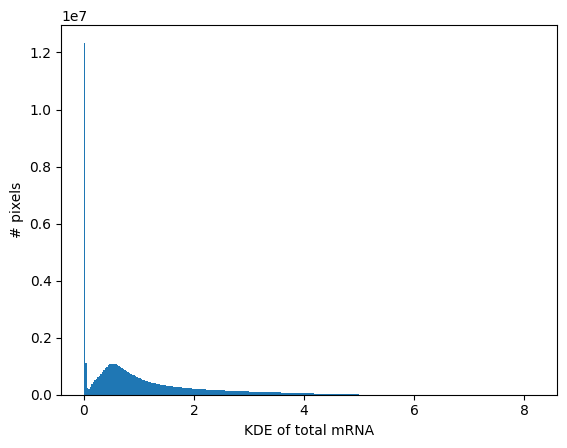

In [11]:
_ = xenium_sainsc.plot_KDE_histogram(bins=300)

In [12]:
xenium_sainsc.filter_background(0.1)

In [13]:
ssam_fast_ctmap_no_background = ssam_fast_ctmap[~xenium_sainsc.background]

In [14]:
sainsc_ctmap_no_background = xenium_sainsc.celltype_map[
    ~xenium_sainsc.background
].copy()

In [15]:
adjusted_rand_score(ssam_fast_ctmap_no_background, sainsc_ctmap_no_background)

0.8643343787681752

In [16]:
normalized_mutual_info_score(ssam_fast_ctmap_no_background, sainsc_ctmap_no_background)

0.8620101081184838

In [17]:
cm = confusion_matrix(
    ssam_fast_ctmap_no_background, sainsc_ctmap_no_background, normalize="true"
)
cm = pd.DataFrame(cm, columns=xenium_sainsc.celltypes, index=xenium_sainsc.celltypes)

In [19]:
cm.to_csv(result_dir / "confusion_matrix.tsv", sep="\t")

In [24]:
diff = ssam_fast_ctmap != xenium_sainsc.celltype_map

assignment_concordance = (
    pd.DataFrame(
        {
            "background": xenium_sainsc.background.flatten(),
            "Assignment score": xenium_sainsc.assignment_score.flatten(),
            "Concordant assignment": ~diff.flatten(),
            "sainsc": xenium_sainsc.celltype_map.flatten(),
        }
    )
    .loc[lambda df: df["sainsc"] != -1]
    .drop(columns=["sainsc"])
)

In [25]:
assignment_concordance.loc[
    lambda df: ~df["background"], "Concordant assignment"
].value_counts()

Concordant assignment
True     45159261
False     3559749
Name: count, dtype: int64

In [26]:
order = ["sainsc", "SSAM (fast KDE)", "SSAM"]

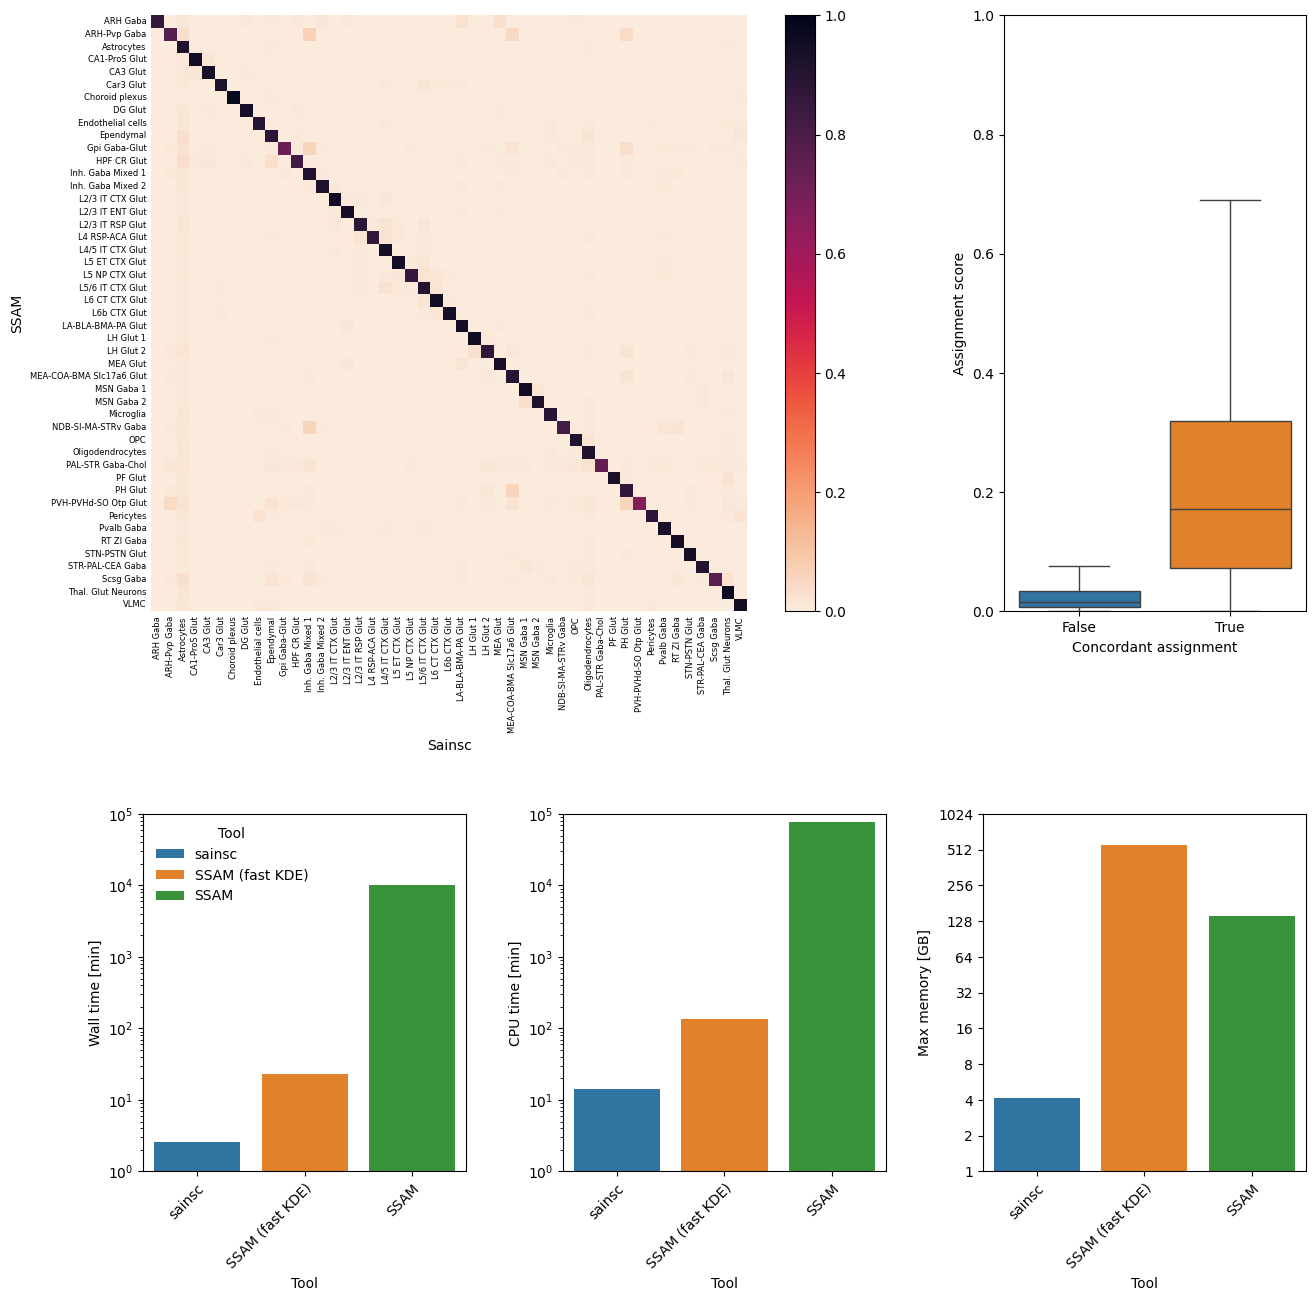

In [38]:
fig = plt.figure(figsize=(15, 13))

subfigures = fig.subfigures(
    nrows=2, height_ratios=[10, 6], hspace=0.1
)  # , hspace=0.1, wspace=-0.05

axs = subfigures[0].subplots(ncols=2, width_ratios=[2.5, 1])
sns.heatmap(
    cm,
    square=True,
    vmin=0,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    ax=axs[0],
    cmap="rocket_r",
)
_ = axs[0].set(xlabel="Sainsc", ylabel="SSAM")
_ = axs[0].tick_params(axis="both", which="both", length=0)

for tick_label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    tick_label.set_fontsize(6)

for spine in subfigures[0].get_children()[-1].spines.values():
    spine.set(visible=True)

sns.boxplot(
    data=assignment_concordance.loc[lambda df: ~df["background"]],
    y="Assignment score",
    hue="Concordant assignment",
    x="Concordant assignment",
    fliersize=0,
    ax=axs[1],
    legend=False,
)
axs[1].set_ylim(0, 1)


axs = subfigures[1].subplots(ncols=3)
subfigures[1].subplots_adjust(wspace=0.3)

for i, metric in enumerate(["Wall time [min]", "CPU time [min]", "Max memory [GB]"]):
    legend = i == 0
    sns.barplot(
        data=stats,
        x="Tool",
        y=metric,
        hue="Tool",
        legend=legend,
        ax=axs[i],
        order=order,
        hue_order=order,
    )
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
    )
    if legend:
        axs[i].get_legend().set(frame_on=False)

axs[0].set(ylim=(1, 100_000), yscale="log")
axs[1].set(ylim=(1, 100_000), yscale="log")

y_scale_memory = [2**i for i in range(11)]
axs[2].set(
    ylim=(1, max(y_scale_memory)),
    yscale="log",
    yticks=y_scale_memory,
    yticklabels=y_scale_memory,
)
axs[2].minorticks_off()

In [39]:
fig.savefig("figures/Fig_SSAM_vs_sainsc_w_CM.pdf", dpi=600, bbox_inches="tight")